In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## train.csv数据分析
train.csv包含字段有：
- store_nbr：表示这个商品在哪个商店（对应的id）被卖掉
- family：商品的类别
- onpromotion：给定**某类商品**在某个**商店**被促销的数量（数量可以是小数，有的商品可以不按整数来卖，比如买1.5kg猫粮）
- sales：**某类商品**在某个**商店**实际销售量（同样可以是小数），这个字段也就是我们要预测的对象

这里需要注意的是，我们要预测的是某类商品在某个商店的销量  
<div>
<img src="store.png" width="400"/>
</div>

In [2]:
# 先从train.csv开始分析数据
# 用pandas读取数据
data_dir = 'store-sales-time-series-forecasting'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [3]:
# 数据的时间维度是'date'，首先看一下date有哪些值
# 从结果中可以看出，date包含了从2013-01-01到2017-8-15的数据，总共1684个时间节点
print(train_df.date.unique())
print(train_df.date.unique().shape)

['2013-01-01' '2013-01-02' '2013-01-03' ... '2017-08-13' '2017-08-14'
 '2017-08-15']
(1684,)


In [4]:
# 看一下'2013-01-01'的数据是怎么样的
# 可以看到，一天的数据包含了1782行数据
first_day_df = train_df[train_df.date == '2013-01-01']
first_day_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...,...
1777,1777,2013-01-01,9,POULTRY,0.0,0
1778,1778,2013-01-01,9,PREPARED FOODS,0.0,0
1779,1779,2013-01-01,9,PRODUCE,0.0,0
1780,1780,2013-01-01,9,SCHOOL AND OFFICE SUPPLIES,0.0,0


In [5]:
# 另外，再看一下一天的数据里面，有哪些商品类别，有哪些商店
# 可以看到，一天的数据中，有54家商店，有33个商品，两两组合一下，刚好是1782行
# 那么可以确定，在每一天里，每一对 商店商品，都有一个销售数据
print(first_day_df.store_nbr.unique())
print(first_day_df.store_nbr.unique().shape)
print(first_day_df.family.unique())
print(first_day_df.family.unique().shape)

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
(54,)
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
(33,)


In [6]:
# 不妨先从第一个组合 1-AUTOMOTIVE 开始，看一下销售数据量是怎么变化的
store_nbr = 1
family = 'AUTOMOTIVE'

# 这里语法比较讲究，&的优先级是高于==的，所以必须用两个小括号分别括起来
# 具体可以参考https://appdividend.com/2019/01/25/pandas-boolean-indexing-example-python-tutorial/
df_store_family = train_df[(train_df.store_nbr == store_nbr) & (train_df.family == family)]
df_store_family

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0
...,...,...,...,...,...,...
2991978,2991978,2017-08-11,1,AUTOMOTIVE,1.0,0
2993760,2993760,2017-08-12,1,AUTOMOTIVE,6.0,0
2995542,2995542,2017-08-13,1,AUTOMOTIVE,1.0,0
2997324,2997324,2017-08-14,1,AUTOMOTIVE,1.0,0


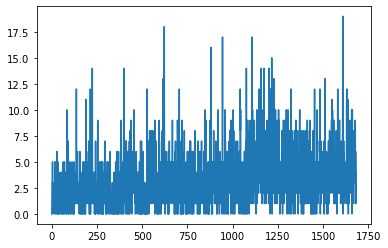

In [7]:
# 把销售量画出来看看效果
# 有点遗憾，好像并没有什么规律，我们先放一下，分析一下其它文件
plt.plot(df_store_family.sales.values)

## stores.csv数据分析
stores.csv记录了商店的信息，字段包括
- store_nbr：商店id
- city：商店位于的城市
- state：商店位于哪个州
- cluster：商店的聚类。意思是说，距离比较相近的商店，被归为一类，用这个cluster代表聚类的类别

这里有一个比较关键的信息，就是cluster  
一般来说，距离比较相近的商店，可能会互为替代品，那么他们整体组合在一起，就可以视为一个整体  
也许个体的销售量没有什么规律，但整体的销售量可能会更有规律  
那么我们的思路可以是，**预测一个聚类整体的销售量**，然后再把销售量**均摊**到聚类的每一个商店个体

In [8]:
stores_df = pd.read_csv(os.path.join(data_dir, 'stores.csv'))
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## 利用商店的聚类信息重新进行销售量预测

In [9]:
store_cluster = set(stores_df[stores_df.cluster == 13].store_nbr)
store_cluster_df = train_df[train_df.store_nbr.isin(store_cluster)]
# 这个strip是因为有个坑，date字段有自带了一个空格，如果不去掉后面的groupby会报错
store_cluster_df.columns = store_cluster_df.columns.str.strip()
store_cluster_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
3000784,3000784,2017-08-15,6,POULTRY,434.570000,0
3000785,3000785,2017-08-15,6,PREPARED FOODS,102.341995,0
3000786,3000786,2017-08-15,6,PRODUCE,2073.636000,5
3000787,3000787,2017-08-15,6,SCHOOL AND OFFICE SUPPLIES,0.000000,0


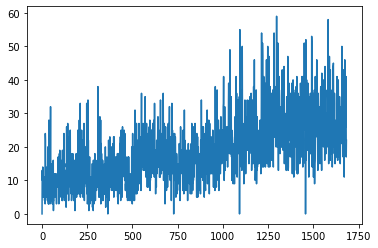

In [10]:
# 看一下cluster 13的'AUTOMOTIVE'商品的销售量
df_store_family = store_cluster_df[store_cluster_df.family == 'AUTOMOTIVE'].groupby('date').sum()
plt.plot(df_store_family.sales.values)

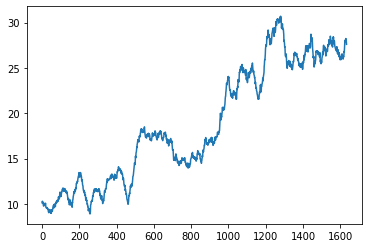

In [11]:
# 上面的数据噪声太多，我们不妨做一下平滑
# 这里我们用窗口大小为50的滑动平滑
# 看起来还是比较有规律的
N = 50
sales_smooth = np.convolve(df_store_family.sales.values, np.ones((N,))/N, mode='valid') 
plt.plot(sales_smooth)

接着，我们正式实现时间序列预测算法
最简单的算法叫做SMA（simple moving average），它的思路很简单，就是前面一段时间的平均值作为下一个时刻的预测值。用数学语言表达就是：
$$
y_{t+1} = \frac{\sum_{i=t-N}^{t}y_t}{N}
$$
比如，我们知道历史数据[10, 20, 30, 35, 30, 25]，假设N=3，那么下一个时刻预测的值就是(40 + 50 + 40) / 3 = 30

In [12]:
def simple_moving_average(history, N):
    """简单滑动平均函数
    
    输入参数：
        - history：一个list，包含了可观测到的历史数据
        - N：滑动窗口的大小
    输出：
        - y_pred：下一个时刻预测值
    """
    # 没错，就是那么简单
    return np.mean(history[-N:])

## test.csv和sample_submission.csv数据分析
在使用SMA进行预测前，我们先得看一下test.csv，看看我们需要预测哪些数据  
test.csv包含了train.csv包含的所有特征字段，但没有sales字段，因为sales字段就是我们需要预测的字段  
可以观察到，date的跨度为16天，也就是我们需要为每一对 商店-商品 **往后预测16天**的销售量数据  
  
sample_submission.csv是我们要提交的答案格式  

In [13]:
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [14]:
test_df

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [15]:
sample_submission_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [16]:
# 提交格式就是一列id，一列预测的sales
sample_submission_df

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [17]:
# 把之前往后预测16天
# 窗口大小设置为30
num_predictions = 16
N = 30
history = sales_smooth.tolist()
for i in range(num_predictions):
    y_pred = simple_moving_average(history, N)
    history.append(y_pred)

# 获得预测的最后16天的数据
history[-num_predictions:]

[26.922666666666665,
 26.95608888888889,
 26.98529185185185,
 27.016134913580245,
 27.046006077366258,
 27.0628729466118,
 27.08030204483219,
 27.098312112993263,
 27.129589183426372,
 27.163908822873918,
 27.20137245030305,
 27.240084865313158,
 27.282087694156925,
 27.31482395062882,
 27.352651415649785,
 27.38773979617144]

之后我们要做的事情还有：
- 把cluster的销售量分摊到每一个商店
- 每一对 商店-商品 都重复进行同样的操作
- 把预测数据填到submission里面去
- 提交结果，查看分数
  
我们直接看整合在一起的代码

## 整合在一起，封装成函数

In [ ]:
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


# 读取各个数据表
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
stores_df = pd.read_csv(os.path.join(data_dir, 'stores.csv'))
sample_submission_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))


def simple_moving_average(history, N):
    """简单滑动平均函数
    
    输入参数：
        - history：一个list，包含了可观测到的历史数据
        - N：滑动窗口的大小
    输出：
        下一个时刻预测值
    """
    # 没错，就是那么简单
    return np.mean(history[-N:])


def predict_cluster(sales, num_predictions, N):
    """预测一个cluster未来几天的销量走势
    
    输入参数：
        - sales：一个numpy array，记录了销售历史
        - num_predictions：预测的天数
        - N：滑动窗口的大小
    输出：
        一个list，代表未来一段时间的销量走势
    """
    history = sales.tolist()
    for i in range(num_predictions):
        y_pred = simple_moving_average(history, N)
        history.append(y_pred)
    return history[-num_predictions:]


def get_store_cluster(store_nbr):
    """查询一个商店所在的cluster id"""
    return int(stores_df[stores_df.store_nbr == store_nbr].cluster.values[0])
    

def predict_store_family_sale(store_nbr, family):
    """预测一对 (商店-商品) 未来15天的销量
    方法就是前面说的，预测该商店所在的cluster的该商品的销量，然后均摊到这个商店
    
    输入参数：
        - store_nbr：商店id
        - family：商品类别
    输出：
        一个numpy array，该  (商店-商品) 未来16天的销量
    """
    cluster_id = get_store_cluster(store_nbr)
    # 找到同个聚类中所有的商店
    store_cluster = set(stores_df[stores_df.cluster == cluster_id].store_nbr)
    # 找到这个聚类中所有商店的销售记录
    store_cluster_df = train_df[train_df.store_nbr.isin(store_cluster)]
    # 这个strip是因为有个坑，date字段有自带了一个空格，如果不去掉后面的groupby会报错
    store_cluster_df.columns = store_cluster_df.columns.str.strip()
    # 找到这些商店销售的这个商品的记录
    df_store_family = store_cluster_df[store_cluster_df.family == family]
    # 根据date做聚合，把同一天的销量加在一起
    df_store_family = df_store_family.groupby('date').sum()
    # 销量做一次滑动平滑
    sales_smooth = np.convolve(df_store_family.sales.values, np.ones((N,))/N, mode='valid')
    # 预测这个cluster未来16天后的销售量
    future = predict_cluster(sales_smooth, num_predictions=16, N=30)
    # 均摊到商店
    future = np.array(future) / len(store_cluster)
    return future.tolist()


def get_all_store_family_pairs():
    """获得所有 (商店-商品) 的组合"""
    pairs = []
    for store_nbr in test_df.store_nbr.unique():
        for family in test_df.family.unique():
            pairs.append((store_nbr, family))
    return pairs


def main():
    """主函数入口"""
    pairs = get_all_store_family_pairs()
    for store_nbr, family in tqdm(pairs):
        future = predict_store_family_sale(store_nbr, family)
        # 找出预测出来的行对应的index
        indexes = test_df[(test_df.store_nbr == store_nbr) & (test_df.family == family)].index
        sample_submission_df.loc[indexes, ['sales']] = future
    sample_submission_df.to_csv('my_submission.csv', index=False)
    
main()

 34%|█████████████▌                          | 602/1782 [00:20<00:42, 27.55it/s]

## 在Kaggle上面提交结果！
链接：https://www.kaggle.com/competitions/store-sales-time-series-forecasting/leaderboard

<div>
<img src="submittion_result.png" width="800"/>
</div>
  
Score = 0.60028，排名 = 479，你们应该能做得更好hhh

## 还有哪些可以改进的地方？
1）预测算法是最简单的SMA，有没有其它更准的算法？可以看一下传统的时间序列算法，比如EMA、Prophet、ARIMA，以及深度学习模型，比如GRU、LSTM、Informer。  
2）一个商店集群的销量均摊到每个商店上，这个设定是不是合理？每个商店是一样的吗？  
3）甚至预测一个商店集群这个想法是不是合理的？有没有更好的办法？  
4）还有几个数据没有用，比如oil.csv记录了油价信息，这个国家的商品销量跟油价有很强的相关性，还有holiday.csv，记录了假期信息，假期可能东西更好卖一些？  
5）不同商品的销售量pattern应该不太一样吧？是不是可以对商品信息做一些分析？